In [34]:
import pandas as pd
import numpy as np
import time
from pycaret.classification import *

In [62]:
def check_class_ratio(dataset):
    class_ratio = round(np.mean(dataset.circ_next_12h), 2)
    return class_ratio

def random_split_stay(df, train_ratio, Threshold, n_trial):
    data = df.copy()
    
    search_time = time.time()
    
    for T in range(n_trial):
        array = data.subject_id.unique()
        
        # seed = np.random.randint(0, 10000, 1)
        seed = 3582
        np.random.seed(seed) 
        np.random.shuffle(array)


        split_point = int(train_ratio * len(array))
        stay_for_train, stay_for_test = np.split(array, [split_point])

        

        condition_train = data.subject_id.isin(stay_for_train)
        holdout_train = data[condition_train]

        condition_test = data.subject_id.isin(stay_for_test)
        holdout_test = data[condition_test]
        
        # holdout_test = holdout_test.sort_values(by=['subject_id',  'stay_id', 'Time_since_ICU_admission']) 
        # holdout_train = holdout_train.sort_values(by=['subject_id',  'stay_id', 'Time_since_ICU_admission']) 

        train_class_ratio  = check_class_ratio(holdout_train)
        test_class_ratio  = check_class_ratio(holdout_test)
                
            
        if (train_class_ratio - test_class_ratio) >= Threshold:
            
            break  # 클래스 비율이 모두 threshold 이상일 경우 반복문 종료
        
        if T % 100 == 0:
            print('Trial: ', T)
            
        if T % 10000 == 0:
        
            Threshold = Threshold + 0.05
            print('Threshold 조정 + 0.05, 현재 한계값: {}'.format(Threshold))
        
        if T == 9999:
            print('최대 Trial 달성, 분할 불가')
        
    train = holdout_train.copy()
    test = holdout_test.copy()
    search_time_end = time.time()
    
    trn_class1 = train.circ_next_12h.value_counts()[0]
    trn_class2 = train.circ_next_12h.value_counts()[1]
    
    tes_class1 = test.circ_next_12h.value_counts()[0]
    tes_class2 = test.circ_next_12h.value_counts()[1]

    
    
    print('train set : test set = {} : {}'.format(train_ratio, 1-train_ratio))
    print('Train set class: ', train.circ_next_12h.value_counts().sort_index())
    print('Test set class: ', test.circ_next_12h.value_counts().sort_index())
    print('-'*20)
    print('Train class ratio: {}:{}'.format((trn_class1)/(trn_class1+trn_class2), (trn_class2)/(trn_class1+trn_class2)))
    print('Test class ratio: {}:{}'.format((tes_class1)/(tes_class1+tes_class2), (tes_class2)/(tes_class1+tes_class2)))
    print('-'*20)
    print('Number of trainset patient:', len(train.subject_id.unique()))
    print('Number of testset patient:', len(test.subject_id.unique()))
    print('Number of trainset stay:', len(train.stay_id.unique()))
    print('Number of testset stay:', len(test.stay_id.unique()))
    print('-'*20)
    print('Split seed: ',seed)
    print('train ratio:', train_ratio)
    print('Threshold:', Threshold)
    print('-'*20)
    print('총 소요 시간(초):{}'.format(search_time_end - search_time))
    print('시도한 trial 수: ', T)
    
    return train, test, stay_for_train, stay_for_test

In [36]:
dataset = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/mimic_df.csv', index_col = 0, compression='gzip')

In [37]:
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

dataset['pao2/fio2_fillna']=0
idx = dataset[dataset['pao2/fio2'].isnull()].index
dataset['pao2/fio2'].loc[idx]=0
dataset['pao2/fio2_fillna'].loc[idx]=1

In [209]:
def filter_classes_with_condition(df):
    filtered_df = df[df['classes'].isin([0, 1, 3, 4])]
    class_3_subset = filtered_df[(filtered_df['classes'] == 3)|(filtered_df['classes'] == 4)].sample(frac=1) 

    class_0_1_df = filtered_df[filtered_df['classes'].isin([0, 1])]
    result_df = pd.concat([class_0_1_df, class_3_subset])

    return result_df

In [210]:
mimic_train_ori, mimic_valid_ori, trn_patient, val_patient = random_split_stay(dataset, 0.7, Threshold=0.05, n_trial=1) 
mimic_train_ori_sampling = filter_classes_with_condition(mimic_train_ori)

Trial:  0
Threshold 조정 + 0.05, 현재 한계값: 0.1
train set : test set = 0.7 : 0.30000000000000004
Train set class:  0.0    971665
1.0    256070
Name: circ_next_12h, dtype: int64
Test set class:  0.0    431215
1.0    114522
Name: circ_next_12h, dtype: int64
--------------------
Train class ratio: 0.7914289321392646:0.20857106786073543
Test class ratio: 0.7901516664620504:0.2098483335379496
--------------------
Number of trainset patient: 7515
Number of testset patient: 3221
Number of trainset stay: 8381
Number of testset stay: 3596
--------------------
Split seed:  3582
train ratio: 0.7
Threshold: 0.1
--------------------
총 소요 시간(초):1.047497034072876
시도한 trial 수:  0


In [211]:
# original space, circulatory prediction

input_space_clf_setting = setup(data = mimic_train_ori_sampling.drop(['Unnamed: 0', 'subject_id', 'stay_id', 'hadm_id','Annotation','classes'], axis = 1), target = 'circ_next_12h',
                                test_data = mimic_valid_ori.drop(['Unnamed: 0', 'subject_id', 'stay_id', 'hadm_id','Annotation','classes'], axis = 1),
                                index=False, session_id = 123)

,Description,Value
0,Session id,123
1,Target,circ_next_12h
2,Target type,Binary
3,Original data shape,"(1769184, 184)"
4,Transformed data shape,"(1769184, 184)"
5,Transformed train set shape,"(1223447, 184)"
6,Transformed test set shape,"(545737, 184)"
7,Numeric features,183
8,Preprocess,True
9,Imputation type,simple


In [13]:
# best = compare_models(include = ['svm','lr', 'dt', 'lightgbm', 'xgboost'], fold = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9592,0.7691,0.0406,0.5148,0.0747,0.0688,0.1340,29.7160
lightgbm,Light Gradient Boosting Machine,0.9581,0.8150,0.1247,0.4515,0.1936,0.1791,0.2200,2.4140
xgboost,Extreme Gradient Boosting,0.9558,0.7895,0.1345,0.3756,0.1966,0.1793,0.2053,3.9660
svm,SVM - Linear Kernel,0.9124,0.0000,0.2122,0.2057,0.1773,0.1411,0.1525,3.9540
dt,Decision Tree Classifier,0.9028,0.5821,0.2331,0.1264,0.1635,0.1169,0.1232,6.8560


In [66]:
test_data = mimic_valid_ori.drop(['Unnamed: 0', 'subject_id', 'stay_id', 'hadm_id','Annotation','classes'], axis = 1)

In [212]:
lightgbm = create_model('lightgbm', cross_validation=False, learning_rate=0.1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9875,0.9950,0.9644,0.9757,0.9700,0.9621,0.9621


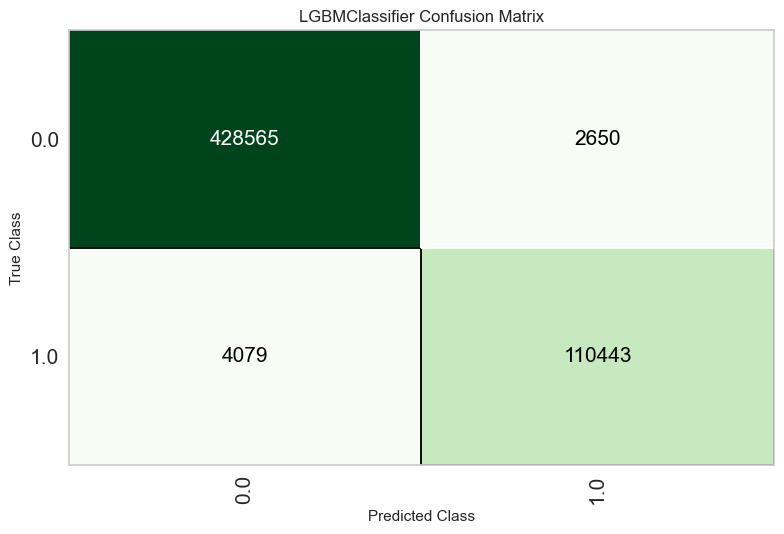

In [183]:
plot_model(lightgbm, plot='confusion_matrix')

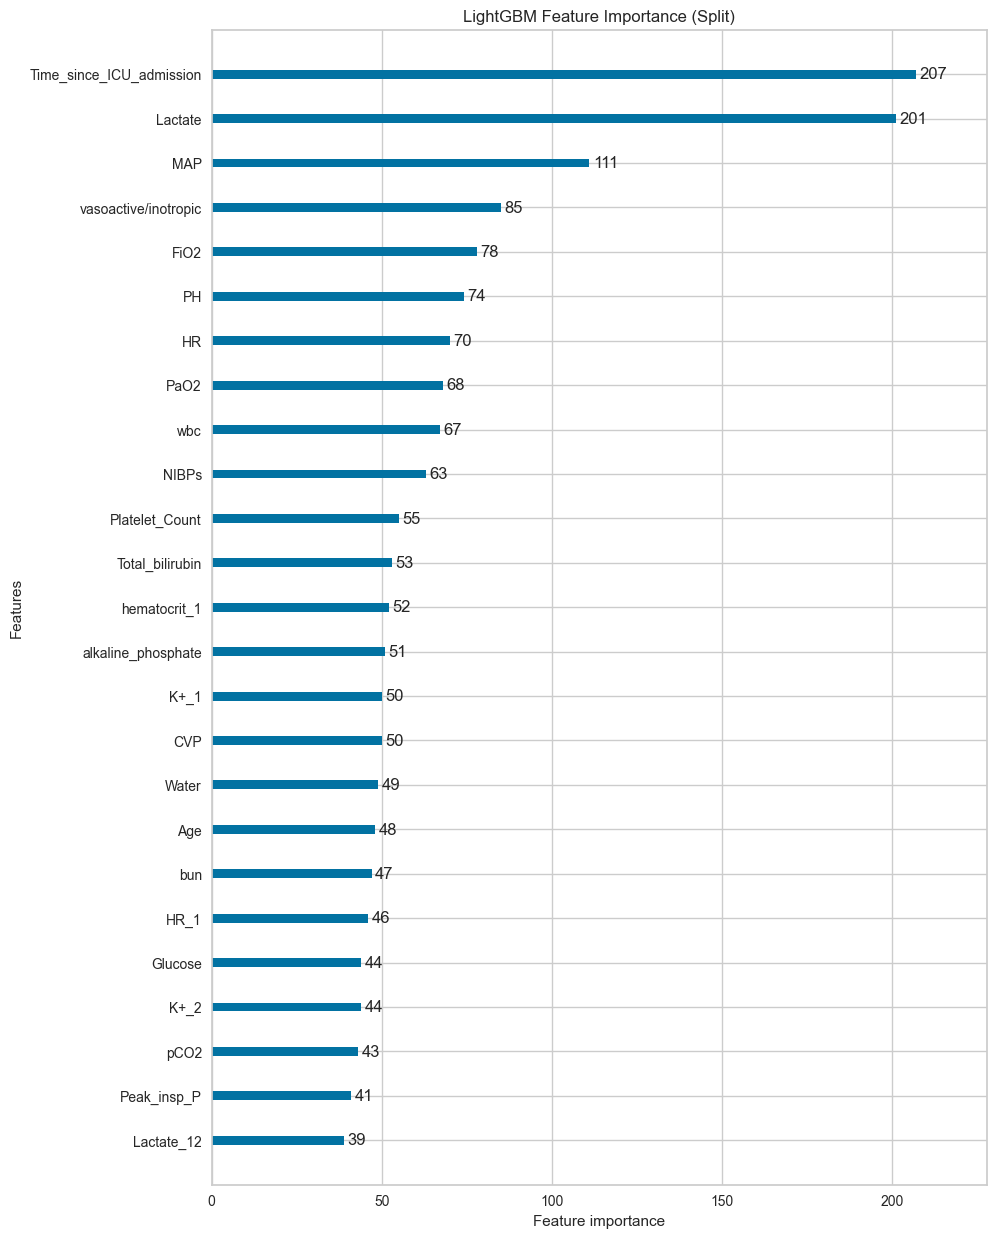

In [213]:
import matplotlib.pyplot as plt
import lightgbm as lgb
lgb.plot_importance(lightgbm, importance_type="split", figsize=(10,15), title="LightGBM Feature Importance (Split)", max_num_features=25)
plt.show()

In [214]:
pred_df = predict_model(lightgbm, data=test_data, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9875,0.9950,0.9644,0.9757,0.9700,0.9621,0.9621


In [215]:
evaluation = mimic_valid_ori[['subject_id', 'stay_id', 'Time_since_ICU_admission', 'Annotation','classes', 'circ_next_12h']].reset_index(drop=True).copy()
evaluation['prediction_label'] = pred_df['prediction_label'].copy()

In [216]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

case2_recall_precision = evaluation[(evaluation['classes']==0) | (evaluation['classes']==1)]

precision = precision_score(case2_recall_precision['circ_next_12h'], case2_recall_precision['prediction_label'])
recall = recall_score(case2_recall_precision['circ_next_12h'], case2_recall_precision['prediction_label'])
 
print('Precision: ',precision)
print('Recall: ',recall)

Precision:  0.33847913093196114
Recall:  0.1440389294403893


In [217]:
import numpy as np
from tqdm import tqdm

def filter_numeric_elements(lst):
    return [x for x in lst if isinstance(x, (int, float))]

def calculate_cap_recall(df, stid):
    # 데이터프레임 복사본 생성
    df_stid = df[df['stay_id'] == stid].copy()

    # 연속적인 circ 이벤트 처리
    df_stid['circ_event'] = (df_stid['Annotation'] == 'circ') & (df_stid['Annotation'].shift(1) != 'circ')

    # circ 이벤트 시작 시점 찾기
    circ_start_times = df_stid[df_stid['circ_event']]['Time_since_ICU_admission'].tolist()
    captured_events = 0
    drop_event = 0
    for start_time in circ_start_times:
        if start_time == df_stid['Time_since_ICU_admission'].values[0]:
            drop_event += 1
        else:
            window_start = start_time - 12
            previous_times = df_stid[(df_stid['Time_since_ICU_admission'] >= window_start) & (df_stid['Time_since_ICU_admission'] < start_time)]

            # 이전 시간 데이터가 없는 경우도 평가에서 제외
            if previous_times.empty:
                drop_event += 1
            elif any(previous_times['prediction_label'] == 1):
                captured_events += 1

    total_events = len(circ_start_times) - drop_event
    if total_events > 0:
        return captured_events / total_events
    else:
        return f'no event in stay id {stid}'  # 또는 적절한 값 반환

# cap_recall 계산
recall = []
for stid in tqdm(evaluation.stay_id.unique()):
    recall.append(calculate_cap_recall(evaluation, stid))

# 숫자만 남기는 함수 적용
filtered_list = filter_numeric_elements(recall)

# numpy를 사용하여 평균 계산
total_recall = np.nanmean(filtered_list)
print(total_recall)

100%|██████████| 3596/3596 [00:03<00:00, 1139.86it/s]

0.44127536231884057


In [269]:
def calculate_precision(df, stid):
    # 특정 stay_id에 대한 데이터만 필터링
    df_stid = df[df['stay_id'] == stid].copy()

    df_stid['circ_event'] = (df_stid['Annotation'] == 'circ') & (df_stid['Annotation'].shift(1) != 'circ')
    circ_start_times = df_stid[df_stid['circ_event']]['Time_since_ICU_admission'].tolist()
    
    # True Alarms와 Total Alarms 초기화
    true_alarms = 0
    total_alarms = 0
    
    # 데이터 프레임의 첫 관측치 시간 가져오기
    first_observation_time = df_stid['Time_since_ICU_admission'].min()
    
    for start_time in circ_start_times:
        # 첫 관측치에서 circ가 시작된 경우, 이를 precision 계산에서 제외
        if start_time == first_observation_time:
            continue
        
        # 이벤트 발생 전 12시간 동안의 예측된 알람 찾기
        window_start = max(start_time - 12, first_observation_time)  # window 시작이 첫 관측치 시간보다 이전이면 첫 관측치 시간으로 설정
        window_end = start_time
        alarms_in_window = df_stid[(df_stid['Time_since_ICU_admission'] >= window_start) & 
                                   (df_stid['Time_since_ICU_admission'] < window_end) & 
                                   (df_stid['prediction_label'] == 1)]
        
        # 전체 알람 (Total Alarms) 계산
        total_alarms += len(alarms_in_window)

        # 진정한 알람 (True Alarms) 계산
        if df_stid.loc[df_stid['Time_since_ICU_admission'] == start_time, 'circ_next_12h'].any():
            true_alarms += len(alarms_in_window)

    # Precision 계산
    precision = true_alarms / total_alarms if total_alarms > 0 else 0  # 알람이 전혀 없으면 precision은 0으로 설정
    
    return precision

# Precision 계산
precisions = []
for stid in tqdm(evaluation['stay_id'].unique()):
    precisions.append(calculate_precision(evaluation, stid))

non_string_indices = [index for index, item in enumerate(recall) if not isinstance(item, str)]
precisions = [precisions[index] for index in non_string_indices]

mean_precision = np.mean([p for p in precisions if isinstance(p, (int, float))])
print(mean_precision)

100%|██████████| 3596/3596 [00:03<00:00, 972.18it/s] 

0.4547826086956522
